In [16]:
import os
import numpy as np
import pandas as pd

import torch
from torchvision import transforms
from torch.autograd import Variable
from models import ResNet50

from PIL import Image, ImageChops
from skimage.measure import compare_ssim

import matplotlib.pyplot as plt

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
ssim_threshold = 0.95

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [25]:
source_path = "./data/imgs"
target_path = "./data/to"

In [26]:
def get_model():
    net = ResNet50()
    net.load_state_dict(torch.load("best_model_chkpt-resnet50.t7", map_location='cpu')['net'])
    return net

In [43]:
cropping = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize(112)
])

preprocessing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

In [27]:
image_dictionary = dict()

for index, row in pd.read_csv("pairs_list.csv").iterrows():
    for source in row['source_imgs'].split('|'):
        image_dictionary[source] = row['target_imgs'].split('|')

In [41]:
model = get_model()
model.eval()

def get_vector_for(img):
    return model(Variable(
        preprocessing(img).unsqueeze(0)
    )).data.numpy().squeeze()

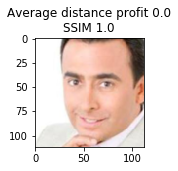

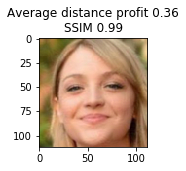

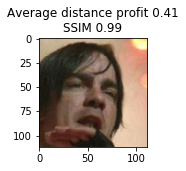

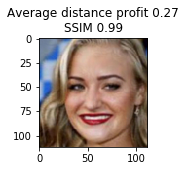

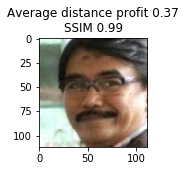

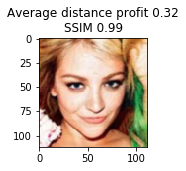

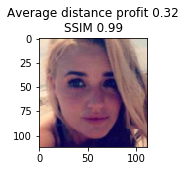

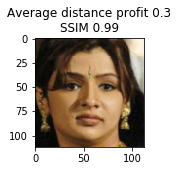

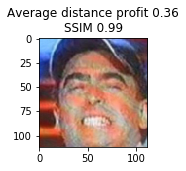

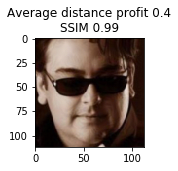

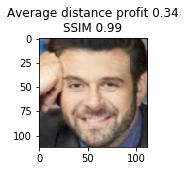

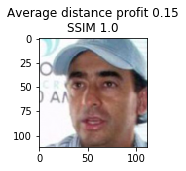

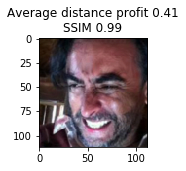

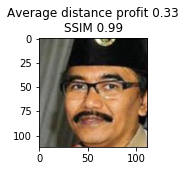

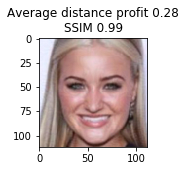

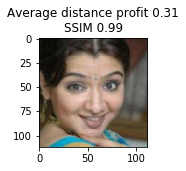

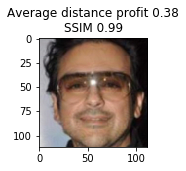

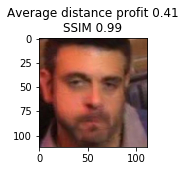

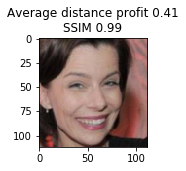

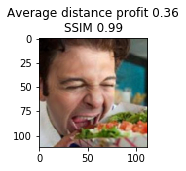

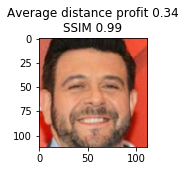

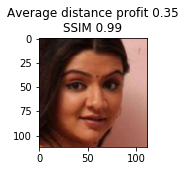

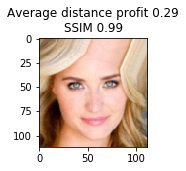

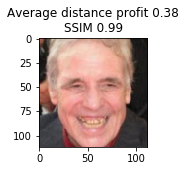

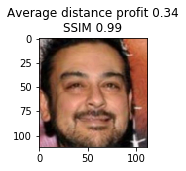

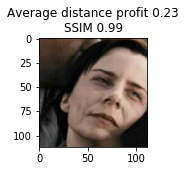

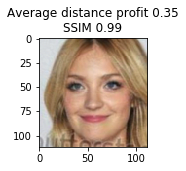

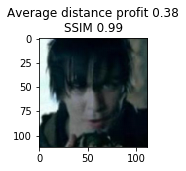

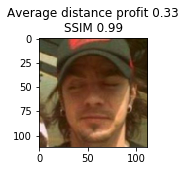

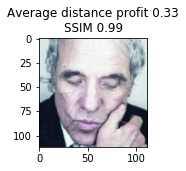

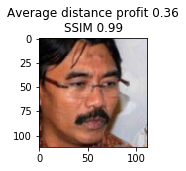

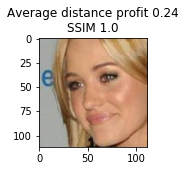

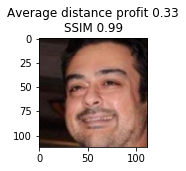

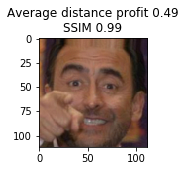

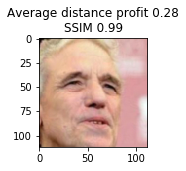

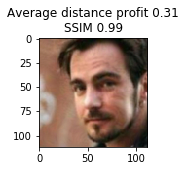

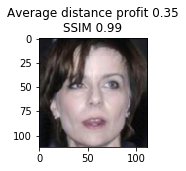

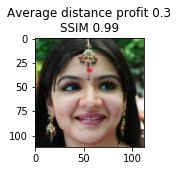

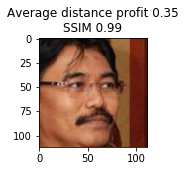

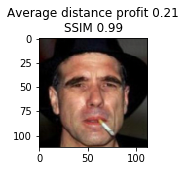

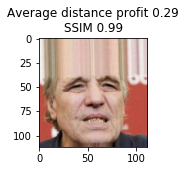

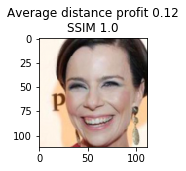

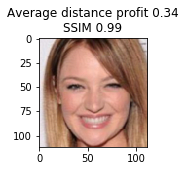

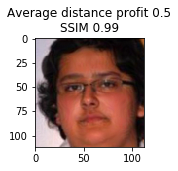

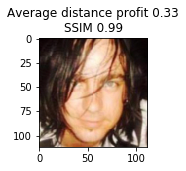

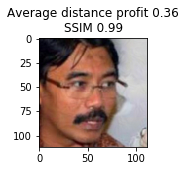

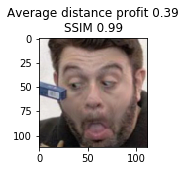

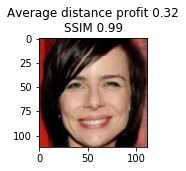

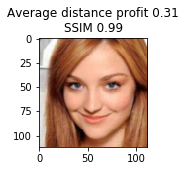

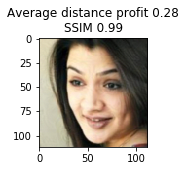

In [59]:
for name in os.listdir(target_path)[1:]:
    full_name = os.path.join(source_path, name.replace('.png', '.jpg'))
    before = cropping(Image.open(full_name))
    after = Image.open(os.path.join(target_path, name))
    
    ssim = compare_ssim(np.array(after), np.array(before), multichannel=True)
    
    before_vector = get_vector_for(before)
    after_vector = get_vector_for(after)
    
    profits = []
    
    for target_name in image_dictionary[name.replace('.png', '.jpg')]:
        target_vector = get_vector_for(
            cropping(Image.open(os.path.join(source_path, target_name)))
        )
        
        profits.append(np.linalg.norm(before_vector - target_vector) -
                       np.linalg.norm(after_vector - target_vector))

    average_profit = np.mean(profits)
    plt.figure(figsize=(2, 2))
    plt.title('Average distance profit {:.2}'.format(average_profit) + '\nSSIM {:.2}'.format(ssim))
    plt.imshow(after)
    plt.show()    